# Problem
Predict the average income of a taxi driver in New York City
- per hour
- per regions

Context \
Give equal opportunities across New York\
\
Initial Areas to look into\
What do you need to know about your data?\
- missing values
- outliers
    - seems over 1000 there are only 23 values for total_amount, so this is likely where there are erroneous values
    - seems over 100 there are only 32 values for trip_distance, so this is likely where erroneous values are
- which columns would give income
- if income is related to distance travelled, then average distance needs to be looked into

What are some possible problems you want to look into?\
How are you going to look for that information?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

In [2]:
taxi_data = pd.read_csv('data/yellow_tripdata_2019-01.csv')
taxi_zone = pd.read_csv('data/taxi+_zone_lookup.csv')

In [3]:
taxi_zone.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [4]:
taxi_zone.shape

(265, 4)

In [5]:
print(taxi_zone['service_zone'].value_counts(),'\n\n' ,taxi_zone['Borough'].value_counts())

Boro Zone      205
Yellow Zone     55
Airports         2
EWR              1
Name: service_zone, dtype: int64 

 Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
Unknown           2
EWR               1
Name: Borough, dtype: int64


In [6]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


In [7]:
taxi_zone['Borough'].unique()

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn',
       'Unknown'], dtype=object)

In [8]:
taxi_data = taxi_data[['tpep_pickup_datetime', 'tpep_dropoff_datetime','passenger_count','trip_distance', 'RatecodeID','PULocationID', 'DOLocationID', 'payment_type','total_amount']]

## Quick Findings

passenger_count
- 0 - 8
- is 0 an error?

trip_distance
- 0 - 800 in miles
- 800 is likely an error

ratecodeid
- should be 1 - 6
- but its seems to have 100 as max - seems to be an error

pulocationid
- 0 - 250
- most common seems to be around 230

dolocationid
- 0 - 250
- most common seems to be around 230

payment_type
- 1 or 2 with 1 the most common

total_amount
- 0 - 600000
- seems to be an error
- there are also some negatives
- count how many are below 0 and above 1000 (1000 being an quick and dirty number to use as a cutoff)

array([[<AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'trip_distance'}>,
        <AxesSubplot:title={'center':'RatecodeID'}>],
       [<AxesSubplot:title={'center':'PULocationID'}>,
        <AxesSubplot:title={'center':'DOLocationID'}>,
        <AxesSubplot:title={'center':'payment_type'}>],
       [<AxesSubplot:title={'center':'total_amount'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

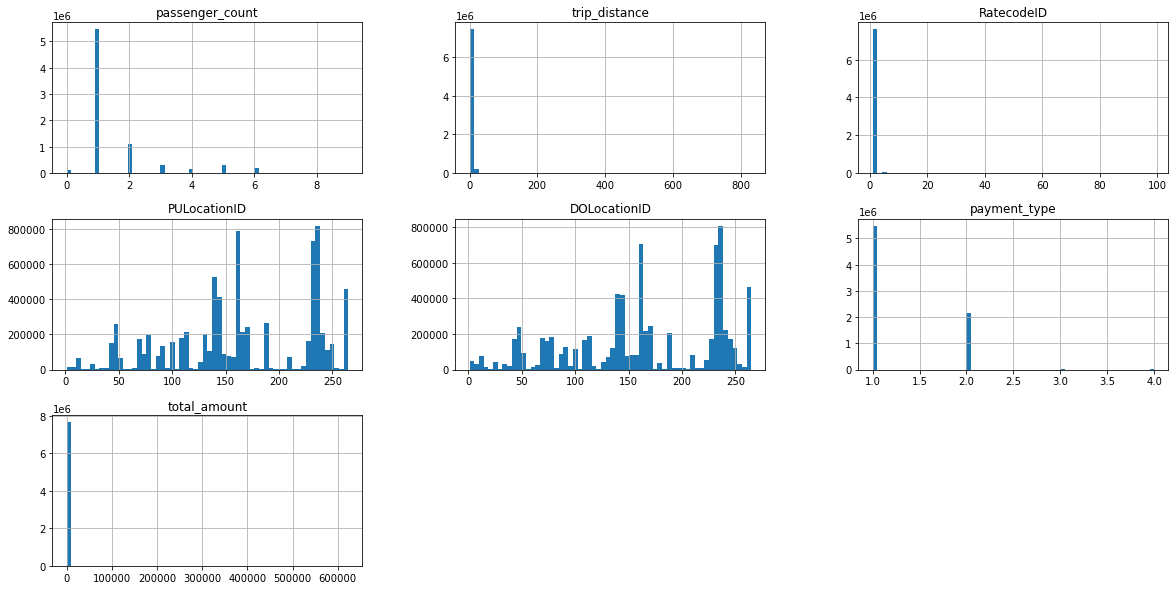

In [9]:
taxi_data.hist(figsize=(20,10), bins = 60)

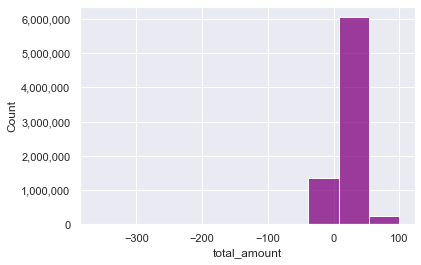

In [10]:
# Load the tips dataset from Seaborn's built-in datasets
# tips = sns.load_dataset("tips")

taxi_data_less_totalamt_100 = taxi_data[taxi_data['total_amount']<100] 
sns.set(style="darkgrid")
# Create a histogram with 20 bins, ranging from 0 to 10

ax = sns.histplot(data=taxi_data_less_totalamt_100, x="total_amount", bins= 10, kde=False, color="purple")
plt.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
sns.set(rc={'figure.figsize':(15,15)})

In [11]:
null_counts = taxi_data.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

total_amount: Getting rid of rows outside of 0 - 200 seems reasonable, its 0.1% of the data


trip_distance: Getting rid of rows above 100 is insignificant. Using this number as its potentialy the max distance to travel in New York?


    - should get rid of 0 values


RatecodeID: Getting rid of rows above 6 is insignificant and confident its correct.


passenger_count: 0 count makes 1.5% of total row count which is more significant than other errors. Do we need this data? Does getting rid of it effect the metrics? If it does, what method could be used to fill the missing value? Is there an inferrence that can be done simple or more complicated...

In [12]:
# total_amount cleaning
row_count = taxi_data.shape[0]
negative_row_count = taxi_data[taxi_data['total_amount']<0].shape[0]
above_200_row_count = taxi_data[taxi_data['total_amount']>200].shape[0]
print('Row Count: '+str(row_count)+'\nNegative Row Count: '+str(negative_row_count)+'\nAbove 200 Row Count: '+str(above_200_row_count))

Row Count: 7667792
Negative Row Count: 7131
Above 200 Row Count: 1166


In [13]:
taxi_data_cleaned = taxi_data[(taxi_data['total_amount']>=0)&(taxi_data['total_amount']<200)]

In [14]:
# total_amount - post clean check
row_count = taxi_data_cleaned.shape[0]
negative_row_count = taxi_data_cleaned[taxi_data_cleaned['total_amount']<0].shape[0]
above_200_row_count = taxi_data_cleaned[taxi_data_cleaned['total_amount']>200].shape[0]
print('Row Count: '+str(row_count)+'\nNegative Row Count: '+str(negative_row_count)+'\nAbove 200 Row Count: '+str(above_200_row_count))

Row Count: 7659490
Negative Row Count: 0
Above 200 Row Count: 0


In [15]:
# trip_distance
row_count = taxi_data_cleaned.shape[0]
above_100_row_count = taxi_data_cleaned[taxi_data_cleaned['trip_distance']>100].shape[0]
print('Row Count: '+str(row_count)+'\nAbove 100 Row Count: '+str(above_100_row_count))

Row Count: 7659490
Above 100 Row Count: 11


In [16]:
taxi_data_cleaned = taxi_data_cleaned[(taxi_data_cleaned['trip_distance']>0)&(taxi_data_cleaned['trip_distance']<=100)]

In [17]:
# trip_distance - post clean check
row_count = taxi_data_cleaned.shape[0]
above_100_row_count = taxi_data_cleaned[taxi_data_cleaned['trip_distance']>100].shape[0]
equal_0_row_count = taxi_data_cleaned[taxi_data_cleaned['trip_distance']==0].shape[0]
print('Row Count: '+str(row_count)+'\nAbove 100 Row Count: '+str(above_100_row_count)+'\nEqual 0 Row Count: '+str(equal_0_row_count))

Row Count: 7606513
Above 100 Row Count: 0
Equal 0 Row Count: 0


In [18]:
# RatecodeID
row_count = taxi_data_cleaned.shape[0]
above_6_row_count = taxi_data_cleaned[taxi_data_cleaned['RatecodeID']>6].shape[0]
print('Row Count: '+str(row_count)+'\nAbove 6 Row Count: '+str(above_6_row_count))

Row Count: 7606513
Above 6 Row Count: 107


In [19]:
taxi_data_cleaned = taxi_data_cleaned[taxi_data_cleaned['RatecodeID']<=6]

In [20]:
# RatecodeID - post clean check
row_count = taxi_data_cleaned.shape[0]
above_6_row_count = taxi_data_cleaned[taxi_data_cleaned['RatecodeID']>6].shape[0]
print('Row Count: '+str(row_count)+'\nAbove 6 Row Count: '+str(above_6_row_count))

Row Count: 7606406
Above 6 Row Count: 0


In [21]:
# RatecodeID
row_count = taxi_data_cleaned.shape[0]
equal_0_row_count = taxi_data_cleaned[taxi_data_cleaned['passenger_count']==0].shape[0]
print('Row Count: '+str(row_count)+'\nEqual 0 Row Count: '+str(equal_0_row_count)+'\n% Significance :'+ str(round(equal_0_row_count/row_count, 4)*100)+'%')

Row Count: 7606406
Equal 0 Row Count: 115602
% Significance :1.52%


In [22]:
taxi_data_cleaned = taxi_data_cleaned[taxi_data_cleaned['passenger_count']>0]

In [23]:
# RatecodeID - post clean check
row_count = taxi_data_cleaned.shape[0]
equal_0_row_count = taxi_data_cleaned[taxi_data_cleaned['passenger_count']==0].shape[0]
print('Row Count: '+str(row_count)+'\nEqual 0 Row Count: '+str(equal_0_row_count)+'\n% Significance :'+ str(round(equal_0_row_count/row_count, 4)*100)+'%')

Row Count: 7490804
Equal 0 Row Count: 0
% Significance :0.0%


- [x] total_amount [restricted data to between 0 - 1000 total_amount]
- [x] trip_distance [restricting data below 100]
- [x] ratecodeid [restricted daat to below/equal to 6]
- [x] passenger_count

Next steps would be to identify what about the metrics that can predict total_amount

In [24]:
taxi_data_cleaned[taxi_data_cleaned['trip_distance']==0]['trip_distance'].value_counts()

Series([], Name: trip_distance, dtype: int64)

In [25]:
taxi_data_cleaned.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,163,229,1,9.05
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,229,7,1,18.50
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,141,234,1,13.00


## Preparation

In [26]:
taxi_data_prepared = taxi_data_cleaned.copy()

In [27]:
taxi_data_prepared.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
payment_type               int64
total_amount             float64
dtype: object

In [28]:
taxi_data_prepared['tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'])
taxi_data_prepared['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared['tpep_dropoff_datetime'])

In [29]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
total_amount                    float64
dtype: object

In [30]:
taxi_data_prepared['RatecodeID'] = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared['PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared['DOLocationID'] =taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared['payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [31]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [32]:
taxi_data_prepared['transaction_date'] = taxi_data_prepared['tpep_pickup_datetime'].dt.date
taxi_data_prepared['transaction_year'] = taxi_data_prepared['tpep_pickup_datetime'].dt.year
taxi_data_prepared['transaction_month'] = taxi_data_prepared['tpep_pickup_datetime'].dt.month
taxi_data_prepared['transaction_day'] = taxi_data_prepared['tpep_pickup_datetime'].dt.day
taxi_data_prepared['transaction_hour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour
taxi_data_prepared['transaction_weekday'] = taxi_data_prepared['tpep_pickup_datetime'].dt.dayofweek

In [33]:
taxi_data_prepared.tail()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_weekday
7667783,2019-01-31 23:04:25,2019-01-31 23:17:09,2,4.15,1,186,13,2,15.80,2019-01-31,2019,1,31,23,3
7667784,2019-01-31 23:32:34,2019-01-31 23:41:40,1,1.34,1,68,233,2,9.30,2019-01-31,2019,1,31,23,3
7667785,2019-01-31 23:47:48,2019-02-01 00:01:08,1,1.45,1,161,229,1,14.16,2019-01-31,2019,1,31,23,3
7667786,2019-01-31 23:31:54,2019-01-31 23:50:36,2,4.28,1,186,262,1,21.96,2019-01-31,2019,1,31,23,3
7667787,2019-01-31 23:57:36,2019-02-01 00:18:39,1,4.79,1,263,4,1,23.16,2019-01-31,2019,1,31,23,3


array([[<AxesSubplot:title={'center':'tpep_pickup_datetime'}>,
        <AxesSubplot:title={'center':'tpep_dropoff_datetime'}>,
        <AxesSubplot:title={'center':'passenger_count'}>],
       [<AxesSubplot:title={'center':'trip_distance'}>,
        <AxesSubplot:title={'center':'total_amount'}>,
        <AxesSubplot:title={'center':'transaction_year'}>],
       [<AxesSubplot:title={'center':'transaction_month'}>,
        <AxesSubplot:title={'center':'transaction_day'}>,
        <AxesSubplot:title={'center':'transaction_hour'}>],
       [<AxesSubplot:title={'center':'transaction_weekday'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

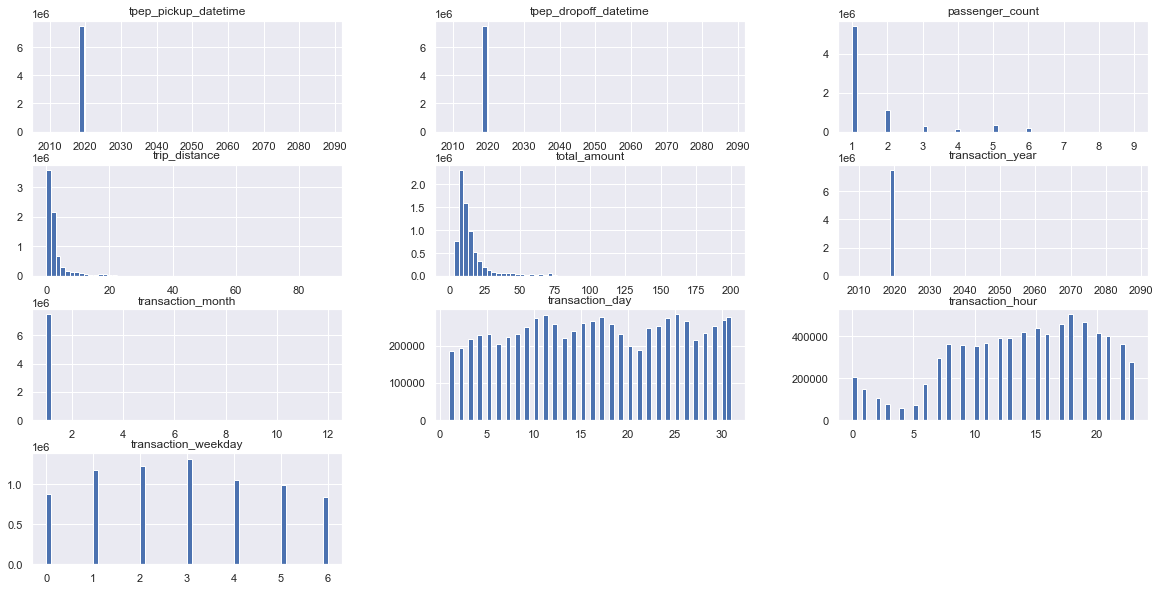

In [34]:
taxi_data_prepared.hist(figsize=(20,10), bins = 60)

In [35]:
# taxi_data_prepared = 
taxi_data_prepared = taxi_data_prepared[(taxi_data_prepared['transaction_year']==2019)&(taxi_data_prepared['transaction_month']==1)]
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_weekday
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,2019,1,1,0,1
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,2019,1,1,0,1
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,163,229,1,9.05,2019-01-01,2019,1,1,0,1
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,229,7,1,18.50,2019-01-01,2019,1,1,0,1
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,141,234,1,13.00,2019-01-01,2019,1,1,0,1


In [36]:
print(taxi_data_prepared.shape)

(7490296, 15)


## Create average distance

In [37]:
zone_distance = pd.read_csv('/Users/tomiwa/Desktop/New-York-Taxi-Analysis/data/zone_distance.csv')
zone_distance.head()

,zone_x,zone_y,distance
0,"Newark Airport, EWR","Newark Airport, EWR",0.000000
1,"Newark Airport, EWR","Jamaica Bay, Queens",27.223241
2,"Newark Airport, EWR","Allerton/Pelham Gardens, Bronx",34.013019
3,"Newark Airport, EWR","Alphabet City, Manhattan",17.086782
4,"Newark Airport, EWR","Arden Heights, Staten Island",14.802332


In [38]:
zone_distance_mean = zone_distance.groupby('zone_x').agg({'distance':'mean'}).reset_index()
zone_distance_mean.reset_index(inplace=True, drop=True)

In [39]:
zone_distance_mean.sort_values(by='distance',ascending=False)

,zone_x,distance
41,"Charleston/Tottenville, Staten Island",35.779526
201,"Rossville/Woodrow, Staten Island",31.406254
80,"Eltingville/Annadale/Prince's Bay, Staten Island",28.885553
95,"Freshkills Park, Staten Island",28.852356
2,"Arden Heights, Staten Island",28.603854
...,...,...
141,"Long Island City/Queens Plaza, Queens",10.966803
76,"East Williamsburg, Brooklyn",10.951067
223,"Sunnyside, Queens",10.945053
106,"Greenpoint, Brooklyn",10.862557


In [40]:
taxi_location_data = taxi_data_prepared[['PULocationID','DOLocationID']]

In [41]:
zone_list = (taxi_zone['Zone']+', '+taxi_zone['Borough']).to_list()
locationid_list = taxi_zone['LocationID'].to_list()
zone_mapping = pd.DataFrame(columns=["locationid", "zone"])
zone_mapping['locationid']=locationid_list
zone_mapping['zone']=zone_list
zone_mapping['locationid']=zone_mapping['locationid'].astype(str)
#zone_mapping.reset_index()
zone_mapping

,locationid,zone
0,1,"Newark Airport, EWR"
1,2,"Jamaica Bay, Queens"
2,3,"Allerton/Pelham Gardens, Bronx"
3,4,"Alphabet City, Manhattan"
4,5,"Arden Heights, Staten Island"
...,...,...
260,261,"World Trade Center, Manhattan"
261,262,"Yorkville East, Manhattan"
262,263,"Yorkville West, Manhattan"
263,264,"NV, Unknown"


In [42]:
zone_distance_location = zone_mapping.copy()
zone_distance_location['distance'] = zone_distance_location['zone'].map(zone_distance_mean.set_index('zone_x')['distance'])

In [43]:
#zone_distance_location[zone_distance_location['locationid']=='216']
zone_distance_location['distance'].fillna(zone_distance_location['distance'].mean(), inplace=True)
zone_distance_location
#zone_distance_location[zone_distance_location['locationid']=='1']

,locationid,zone,distance
0,1,"Newark Airport, EWR",23.026420
1,2,"Jamaica Bay, Queens",17.506916
2,3,"Allerton/Pelham Gardens, Bronx",18.576644
3,4,"Alphabet City, Manhattan",11.234762
4,5,"Arden Heights, Staten Island",28.603854
...,...,...,...
260,261,"World Trade Center, Manhattan",12.526450
261,262,"Yorkville East, Manhattan",11.716461
262,263,"Yorkville West, Manhattan",11.716461
263,264,"NV, Unknown",0.000000


In [44]:
zone_distance_location[zone_distance_location['locationid']=='1']

,locationid,zone,distance
0,1,"Newark Airport, EWR",23.02642


In [45]:
taxi_location_data['puzone'] = taxi_location_data['PULocationID'].map(zone_mapping.set_index('locationid')['zone'])
taxi_location_data['dozone'] = taxi_location_data['DOLocationID'].map(zone_mapping.set_index('locationid')['zone'])

/var/folders/sf/8rk47_f570sgpsxcjwrpxd9m0000gn/T/ipykernel_1022/2362877982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_location_data['puzone'] = taxi_location_data['PULocationID'].map(zone_mapping.set_index('locationid')['zone'])
/var/folders/sf/8rk47_f570sgpsxcjwrpxd9m0000gn/T/ipykernel_1022/2362877982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_location_data['dozone'] = taxi_location_data['DOLocationID'].map(zone_mapping.set_index('locationid')['zone'])


 ## Format

In [46]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_weekday
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,151,239,1,9.95,2019-01-01,2019,1,1,0,1
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,239,246,1,16.30,2019-01-01,2019,1,1,0,1
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.3,1,163,229,1,9.05,2019-01-01,2019,1,1,0,1
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.7,1,229,7,1,18.50,2019-01-01,2019,1,1,0,1
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.1,1,141,234,1,13.00,2019-01-01,2019,1,1,0,1


In [47]:
categorical_columns = [  'transaction_date'
#                         ,'transaction_year'
                        ,'transaction_month'
                        ,'transaction_day'
                        ,'transaction_weekday'
                        ,'transaction_hour'
#                         ,'RatecodeID'
                        ,'DOLocationID'
                        ,'PULocationID']
numerical_columns = ['trip_distance' ,'total_amount']
all_needed_columns = categorical_columns+numerical_columns
taxi_data_condensed = taxi_data_prepared[all_needed_columns]

In [48]:
taxi_data_grouped = taxi_data_condensed.groupby(categorical_columns).agg({'trip_distance': 'mean', 'total_amount': 'mean'}).reset_index()
taxi_data_grouped['count_of_transactions'] = taxi_data_condensed.groupby(categorical_columns).agg({'total_amount':'size'}).reset_index()['total_amount']

In [49]:
print(taxi_data_grouped.shape)

(1836123, 10)


In [50]:
taxi_data_grouped.head()

,transaction_date,transaction_month,transaction_day,transaction_weekday,transaction_hour,DOLocationID,PULocationID,trip_distance,total_amount,count_of_transactions
0,2019-01-01,1,1,1,0,1,216,33.190000,120.80,1
1,2019-01-01,1,1,1,0,1,87,13.900000,84.96,1
2,2019-01-01,1,1,1,0,10,132,3.943333,16.55,3
3,2019-01-01,1,1,1,0,10,161,18.400000,66.06,1
4,2019-01-01,1,1,1,0,10,205,2.220000,10.80,2


In [51]:
def hour_category(x):
    if x>=0 and x<=5:
        output = 1
    if x>5 and x<=15:
        output = 2
    if x>15 and x <=19:
        output = 3
    if x>19:
        output = 1
    return output

taxi_data_grouped['hour_category'] = taxi_data_grouped['transaction_hour'].apply(lambda x: hour_category(x))

In [52]:
taxi_data_grouped['is_weekend'] = taxi_data_grouped['transaction_weekday'].apply(lambda x: 1 if x == 5 or x ==6 else 0)

In [53]:
taxi_zone['LocationID'] = taxi_zone['LocationID'].astype(str)

In [54]:
taxi_data_grouped['borough'] = taxi_data_grouped.merge(taxi_zone, left_on='PULocationID', right_on='LocationID')['Borough']

In [55]:
# taxi_data_grouped_borough_count = taxi_data_grouped.groupby(['transaction_date', 'transaction_hour', 'borough']).agg({'count_of_transactions':'sum'}).reset_index()
# taxi_data_grouped_borough_count['count_of_borough_transactions'] = taxi_data_grouped_borough_count['count_of_transactions']


# taxi_data_grouped['count_of_borough_transactions'] =taxi_data_grouped.merge(taxi_data_grouped_borough_count, left_on=['transaction_date', 'transaction_hour', 'borough'], right_on=['transaction_date', 'transaction_hour', 'borough'])['count_of_borough_transactions']

In [56]:
taxi_data_grouped[['transaction_date', 'transaction_hour', 'borough', 'count_of_borough_transactions']]

KeyError: "['count_of_borough_transactions'] not in index"

In [57]:
taxi_data_grouped[(taxi_data_grouped['transaction_hour']==0) & (taxi_data_grouped['transaction_day']==1)].groupby('borough').agg({'count_of_transactions':'sum'})

,count_of_transactions
borough,
Manhattan,8674
Queens,4477


In [61]:
taxi_data_grouped['distance'] =taxi_data_grouped['PULocationID'].map(zone_distance_location.set_index('locationid')['distance'])
taxi_data_grouped.head()
taxi_data_grouped.dtypes

transaction_date          object
transaction_month          int64
transaction_day            int64
transaction_weekday        int64
transaction_hour           int64
DOLocationID              object
PULocationID              object
trip_distance            float64
total_amount             float64
count_of_transactions      int64
hour_category              int64
is_weekend                 int64
borough                   object
distance                 float64
dtype: object

In [ ]:
taxi_data_grouped.groupby('PULocationID').agg({'total_amount':'mean', 'distance':'mean'}).reset_index().plot(figsize=(20,10), kind='scatter', x='total_amount', y='distance')

## Benchmark Model
Benchmark that needs to be passed\
What can already be done with current features\
Which ones are the input features?\
Which are the target features?\
Day & Hour - in categorical because they have a circular relationship

In [62]:
data_for_benchmark_model = taxi_data_grouped.copy()

In [75]:
categorical_features_benchmark = ['PULocationID','transaction_day','transaction_hour']
input_features_benchmark = categorical_features_benchmark+['count_of_transactions']
target_feature_benchmark = 'total_amount'

In [76]:
#train-test-split
#80%-20% common
#want to have enough data to train model+for testing
#there's a lot of data, so you can go for the highest bordeline in terms of train-test - 1/3train, 2/3test
from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode - turning categories into numbers
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

In [77]:
from sklearn.tree import DecisionTreeRegressor

#hyper parameter, how deep should the decision tree go
#machine learning is finding out the best hyperparameter to use
tree = DecisionTreeRegressor(max_depth=10) 
tree.fit(X_train_b, y_train_b)

DecisionTreeRegressor(max_depth=10)

## model evaluation

In [78]:
model_at_hand = tree
y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
print('r2', r2_score(y_test_b, y_pred_b))

# mean_absolute_error 8.216425240961799
# mean_squared_error 164.92270464146864
# root_mean_squared_error 12.842223508468798
# r2 0.3528356686007662

# mean_absolute_error 9.387320986414851
# mean_squared_error 189.78699317763895
# root_mean_squared_error 13.776320015796633
# r2 0.2552670487966603

mean_absolute_error 8.34420755314254
mean_squared_error 168.7107675117063
root_mean_squared_error 12.988870909809917
r2 0.3379711344540275


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='true', ylabel='pred'>

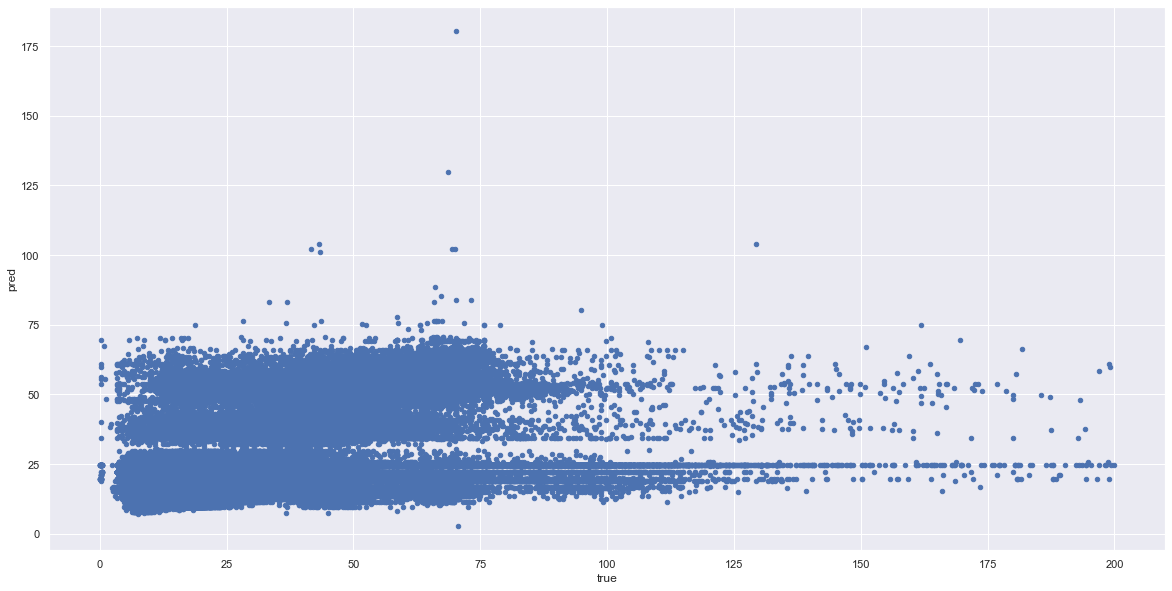

In [79]:
data = {'true':y_test_b, 'pred':y_pred_b}
results = pd.DataFrame(data)
results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

In [80]:
# leakage - including trip distance is cheating if you have no idea how far someone is going to go

<AxesSubplot:>

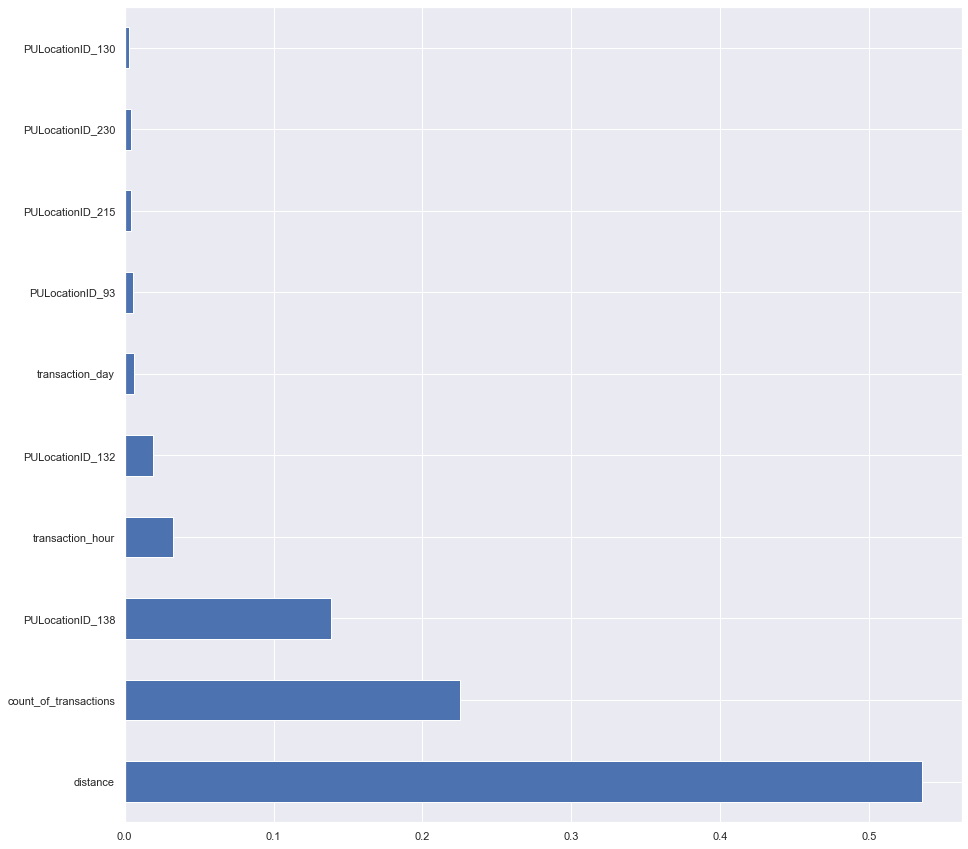

In [70]:
(pd.Series(model_at_hand.feature_importances_, index=X_train_b.columns)
   .nlargest(10)
   .plot(kind='barh')) 

## Identify New Features

In [ ]:
taxi_data_grouped_date = taxi_data_grouped.groupby('transaction_date').agg({'total_amount': 'mean'}).reset_index()
# Create the line graph
x_transaction_date = taxi_data_grouped_date['transaction_date']
y_total_amount = taxi_data_grouped_date['total_amount']
fig = px.line(x=x_transaction_date, y=y_total_amount)

# Show the graph
fig.show()

In [ ]:
taxi_data_grouped_hour = taxi_data_grouped.groupby('transaction_hour').agg({'total_amount': 'mean'}).reset_index()
# Create the line graph
x_transaction_hour = taxi_data_grouped_hour['transaction_hour']
y_total_amount = taxi_data_grouped_hour['total_amount']
fig = px.line(x=x_transaction_hour, y=y_total_amount)

# Show the graph
fig.show()

In [ ]:
taxi_data_grouped_date.head()

In [ ]:
def hour_category(x):
    if x>=0 and x<=5:
        output = 1
    if x>5 and x<16:
        output = 2
    if x>=13 and x <16:
        output = 3
    if x == 16:
        output = 4
    if x>=17 and x<20:
        output = 5
    if x>=20:
        output = 6